<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/L1LossOnly_0.0001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       #transforms.RandomHorizontalFlip(0.1),
                                       #transforms.RandomResizedCrop(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) # output_size = 28

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
        ) # output_size = 16
       
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 16
      

        self.pool2 = nn.MaxPool2d(2,2) # output_size = 8
        
        # TRANSITION BLOCK 2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
        ) # output_size = 8
  
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x) 
        x = self.convblock4(x)
        
        x = self.pool2(x)    
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 20, 28, 28]           1,800
              ReLU-5           [-1, 20, 28, 28]               0
       BatchNorm2d-6           [-1, 20, 28, 28]              40
           Dropout-7           [-1, 20, 28, 28]               0
         MaxPool2d-8           [-1, 20, 14, 14]               0
            Conv2d-9           [-1, 10, 16, 16]             200
           Conv2d-10           [-1, 20, 16, 16]           1,800
             ReLU-11           [-1, 20, 16, 16]               0
      BatchNorm2d-12           [-1, 20, 16, 16]              40
          Dropout-13           [-1, 20, 16, 16]               0
        MaxPool2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  LAMBDA =  0.0001

  criterion = nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    l1_reg_loss = 0
    for param in model.parameters():
      l1_reg_loss += torch.sum(abs(param))

    classify_loss = criterion(y_pred, target)

    #loss = F.nll_loss(y_pred, target)

    loss = classify_loss + LAMBDA * l1_reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:

def find_actual_pred_map(model, num=25):
  images=[]
  target_list=[]
  pred_list=[]
  count=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True).view_as(target)
      for d , t , p in zip(data, target, pred):
        if t!=p:
          d = d.cpu().numpy()
          t = t.cpu().numpy()
          p = p.cpu().numpy()
          d = (d*0.3081)+0.1307
          images.append(d)
          target_list.append(t)
          pred_list.append(p)
          count+=1
        if count == num:
          return images, target_list, pred_list

In [14]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

images, targ, pred = find_actual_pred_map(model, 25)


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13239608705043793 Batch_id=937 Accuracy=89.36: 100%|██████████| 938/938 [00:20<00:00, 46.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0884, Accuracy: 9761/10000 (97.61%)

EPOCH: 1


Loss=0.11162252724170685 Batch_id=937 Accuracy=97.15: 100%|██████████| 938/938 [00:20<00:00, 46.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9795/10000 (97.95%)

EPOCH: 2


Loss=0.09456263482570648 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:19<00:00, 47.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9813/10000 (98.13%)

EPOCH: 3


Loss=0.09633161127567291 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9857/10000 (98.57%)

EPOCH: 4


Loss=0.0782909020781517 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:20<00:00, 46.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.0816965401172638 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:20<00:00, 46.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.23275411128997803 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:19<00:00, 47.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.08857233822345734 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:20<00:00, 46.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9891/10000 (98.91%)

EPOCH: 8


Loss=0.10634226351976395 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9860/10000 (98.60%)

EPOCH: 9


Loss=0.10678908228874207 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:19<00:00, 47.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Loss=0.14132767915725708 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:19<00:00, 47.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.1261255443096161 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:20<00:00, 46.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.17584916949272156 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:20<00:00, 46.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9897/10000 (98.97%)

EPOCH: 13


Loss=0.17754557728767395 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:19<00:00, 47.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


Loss=0.07495737820863724 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:20<00:00, 46.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9907/10000 (99.07%)

EPOCH: 15


Loss=0.13044923543930054 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:20<00:00, 46.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9907/10000 (99.07%)

EPOCH: 16


Loss=0.09561872482299805 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:19<00:00, 55.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9886/10000 (98.86%)

EPOCH: 17


Loss=0.08015423268079758 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:19<00:00, 46.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9888/10000 (98.88%)

EPOCH: 18


Loss=0.07020009309053421 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:20<00:00, 46.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9902/10000 (99.02%)

EPOCH: 19


Loss=0.10889650881290436 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:20<00:00, 46.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9903/10000 (99.03%)

EPOCH: 20


Loss=0.29460465908050537 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:20<00:00, 46.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9898/10000 (98.98%)

EPOCH: 21


Loss=0.07581707090139389 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:20<00:00, 46.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9875/10000 (98.75%)

EPOCH: 22


Loss=0.07347758859395981 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:20<00:00, 46.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9907/10000 (99.07%)

EPOCH: 23


Loss=0.10170158743858337 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:20<00:00, 46.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9914/10000 (99.14%)

EPOCH: 24


Loss=0.07712946832180023 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:19<00:00, 46.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9890/10000 (98.90%)

EPOCH: 25


Loss=0.10269643366336823 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:20<00:00, 46.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9891/10000 (98.91%)

EPOCH: 26


Loss=0.09455408155918121 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:20<00:00, 46.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9915/10000 (99.15%)

EPOCH: 27


Loss=0.18286341428756714 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:20<00:00, 46.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9888/10000 (98.88%)

EPOCH: 28


Loss=0.11268776655197144 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:20<00:00, 46.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9883/10000 (98.83%)

EPOCH: 29


Loss=0.13369768857955933 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:20<00:00, 46.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9909/10000 (99.09%)

EPOCH: 30


Loss=0.32298898696899414 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:20<00:00, 46.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9896/10000 (98.96%)

EPOCH: 31


Loss=0.07858118414878845 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:20<00:00, 46.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9911/10000 (99.11%)

EPOCH: 32


Loss=0.12978766858577728 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:20<00:00, 46.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.09%)

EPOCH: 33


Loss=0.21873386204242706 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:20<00:00, 54.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9923/10000 (99.23%)

EPOCH: 34


Loss=0.06687771528959274 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:20<00:00, 45.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9908/10000 (99.08%)

EPOCH: 35


Loss=0.11347012221813202 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:20<00:00, 45.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9903/10000 (99.03%)

EPOCH: 36


Loss=0.06717292964458466 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:20<00:00, 51.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9903/10000 (99.03%)

EPOCH: 37


Loss=0.09971164166927338 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:20<00:00, 46.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9888/10000 (98.88%)

EPOCH: 38


Loss=0.09700605273246765 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:20<00:00, 46.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 39


Loss=0.06994983553886414 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:20<00:00, 46.63it/s]



Test set: Average loss: 0.0319, Accuracy: 9893/10000 (98.93%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

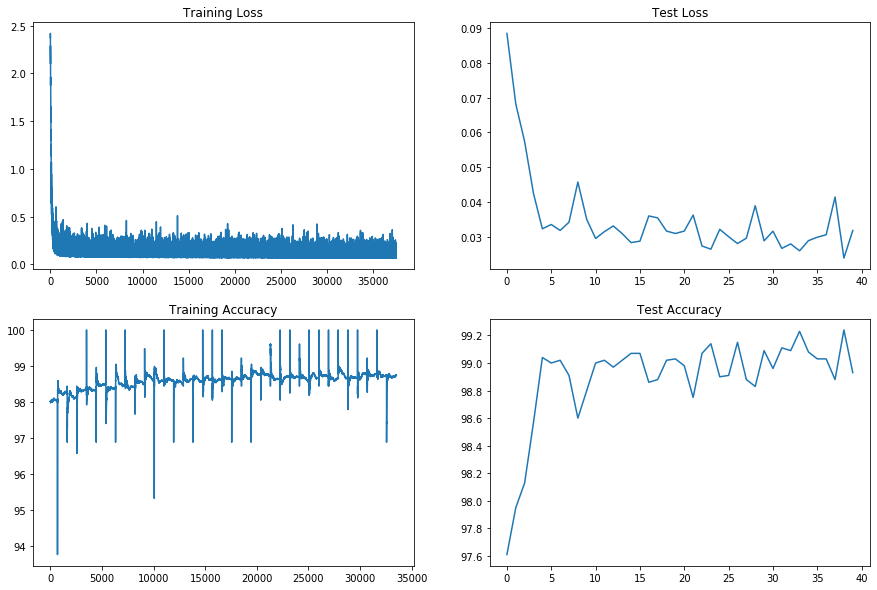

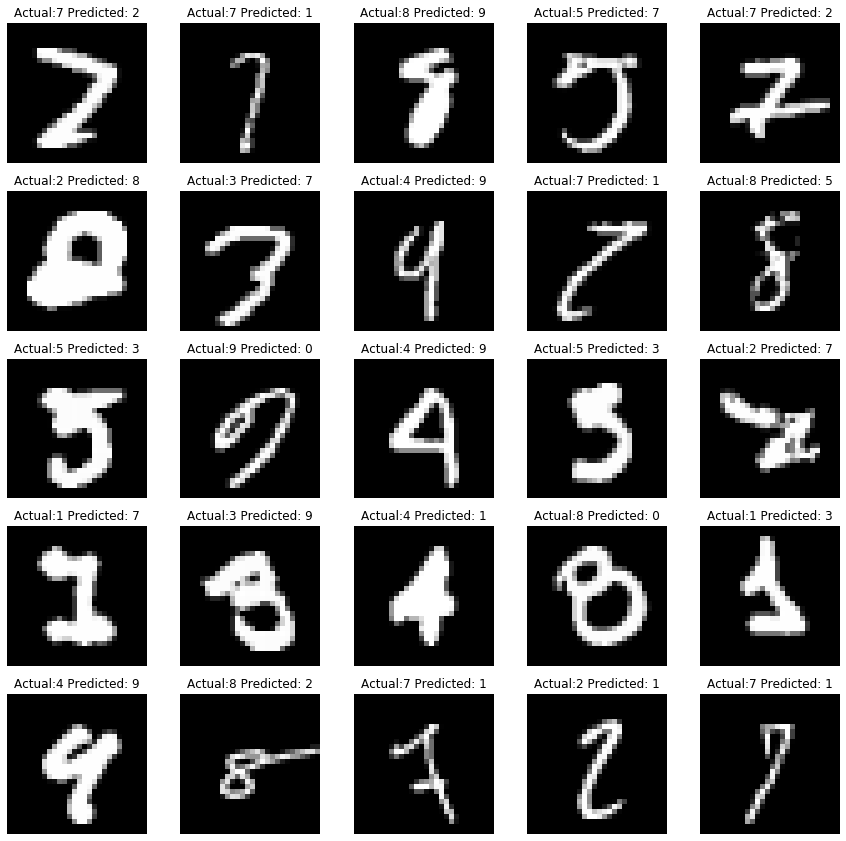

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

fig = plt.figure(figsize=(15, ((25//5)+1)*3))

for i in range(0, 25):
  ax=fig.add_subplot((25//5)+1, 5, i+1)
  ax.imshow(np.rollaxis(images[i], 0, 3).squeeze(), cmap='gray')
  ax.axis('off')
  ax.set_title("Actual:"+str(targ[i])+" Predicted: "+str(pred[i]))

plt.savefig('L1_REG.png')
plt.show()



In [0]:
TARGET: Improve train and test accuracy to reach desired targets within 15 epoch

RESULT: Achieved the target , got 99.45 % test accuracy in EPOCH 13 and there after results remained closer to this accuracy in rest of the epochs.Also the train accuracy slightly improved compared to the previous one.

         Total Params: 9,482
         Best train accuracy: 99.00
         Best test accuracy:  99.45

ANALYSIS: Did not apply drop out in Conv5 layer.Also adding second max pooling earlier has increased the RF to 56